<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Forecasting the S&P 500 Using Macro-Financial Variables</div>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.multitest import multipletests
from scipy.stats import jarque_bera, pearsonr


from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from preprocessor import Preprocessor
from forecaster import Forecaster
from arimaforecaster import ARIMAForecaster
from skew_transformer import SkewTransformer


pd.set_option('display.max_columns', 200)

# Target variable analysis 



- Prices Are Non-Stationary
    - Stock prices typically follow a random walk, making them non-stationary.
    - Non-stationary series can lead to spurious correlations, making it difficult to model relationships with macroeconomic variables.
    - Predicting prices often just extrapolates the trend rather than capturing meaningful economic relationships
    - Strong Autocorrelation

- Arthmetic Returns
    - Stationarity
    -  Arithmetic Returns Are Not Time-Additive
    -  Sensitive to Large Movements

- Log returns
    - They reduce skewness compared to arithmetic returns.
    - This makes long-term return estimation easier since time additive.
    - Stationarity

### Horizons
- A 5-day (weekly) horizon balances short-term market dynamics with medium-term macro trends. Many variables (e.g., 20-day rolling changes, Sharpe ratios) capture trends over weeks & months, making them more relevant for weekly rather than daily forecasts. This reduces noise while maintaining responsiveness to market shifts.
We could try monthly but I believe not enough data


### We will create a model that forecast the weekly log_returns 
The metrics we will use is the RMSE (to penalize large error), MAE if you prefer a more balanced and the DA to check efficienchy in a trading environment

# Preprocessing
- Train test split (with crisis in both set and then time series cross val for feature selecction and tuning)
- Handle missing values and outliers.
- Normalization


Preprocessor class that will do our preprocessing


## Train-Test Split

The idea is to have i both the training and the test set a crisis (2008 and Covid). Then for the training we will use Time Series Split 

## Missing Values
It seems that due to rolling statistics the first rows of the dataset cannot be used:

- We will begin our training after some yers to have more features avaiblable. Howver, we will not delete all,rows until all the rollings statistics are ready because it will cut too much rows of our dataset and avoid the 2008 crisis that i want to keep in my training set.
- For the remaining features we wll delete columns tht exibit a large number of missing values 
- The rest will be imputed with bfill or median imputation

(The idea here is to keep in both the trainig and testing set a crisis (2008/COVID) to have a more robust model)

## Outlier 
(Winsorization/ IQR)
- Tree-Based Models (Random Forest, XGBoost, LightGBM) can handle outliers
- If Outliers Represent Real Market Events (Crashes, Volatility Spikes) it can be useful to keep them

Therefore for now we will keep our outliers evn if further study could be done 

## Normalization
Transforms numerical features into a consistent scale, ensuring that different features contribute equally to a model.



In [3]:
file_path = "data/SP_500_Prices.csv"
sp500 = pd.read_csv(file_path, index_col=0).rename(columns={'US S&P 500':'close'})
sp500.index = pd.to_datetime(sp500.index, format="%Y-%m-%d")
sp500.sort_index(inplace=True)
sp500['log_returns'] = np.log(sp500['close'] / sp500['close'].shift(1))

weekly_sp500 = pd.DataFrame()
weekly_sp500['log_returns'] = sp500['log_returns'].resample('W-FRI').sum()  # Additive
weekly_sp500['close'] = sp500['close'].resample('W-FRI').last()  # Last closing price

sp500 = weekly_sp500.copy()
sp500


,log_returns,close
2003-01-03,-0.001341,99.865974
2003-01-10,0.019857,101.868806
2003-01-17,-0.027114,99.143880
2003-01-24,-0.047113,94.581192
2003-01-31,-0.005924,94.022548
...,...,...
2024-03-22,0.021699,577.532086
2024-03-29,0.002926,579.224350
2024-04-05,-0.010612,573.109903
2024-04-12,-0.016949,563.477982


In [4]:
file_path = "data/features.csv"
features = pd.read_csv(file_path, index_col=0)
features.sort_index(inplace=True)
features.index = pd.to_datetime(features.index)

# Define columns by aggregation type
cols_last = [col for col in features.columns if '_Pct_Chg' in col or '_Chg_' in col or '_Surprise' in col]
cols_mean = [col for col in features.columns if col not in cols_last]

# Perform resampling efficiently using `pd.concat`
resampled_features = pd.concat([
    features[cols_last].resample('W-FRI').last(),
    features[cols_mean].resample('W-FRI').mean()
], axis=1)


features = resampled_features.copy()
features

,SP_500_Pct_Chg_20d,SP_500_Pct_Chg_120d,SP_500_Pct_Chg_250d,Nasdaq_100_Pct_Chg_20d,Nasdaq_100_Pct_Chg_120d,Nasdaq_100_Pct_Chg_250d,Russel_2000_Pct_Chg_20d,Russel_2000_Pct_Chg_120d,Russel_2000_Pct_Chg_250d,Euro_Stoxx_50_Pct_Chg_20d,Euro_Stoxx_50_Pct_Chg_120d,Euro_Stoxx_50_Pct_Chg_250d,FTSE_100_Pct_Chg_20d,FTSE_100_Pct_Chg_120d,FTSE_100_Pct_Chg_250d,Nikkei_225_Pct_Chg_20d,Nikkei_225_Pct_Chg_120d,Nikkei_225_Pct_Chg_250d,MSCI_EM_Pct_Chg_20d,MSCI_EM_Pct_Chg_120d,MSCI_EM_Pct_Chg_250d,US_10Y_Chg_100d,US_10Y_Chg_120d,US_10Y_Chg_250d,US_2Y_Chg_100d,US_2Y_Chg_120d,US_2Y_Chg_250d,US_Real_10Y_Chg_100d,US_Real_10Y_Chg_120d,US_Real_10Y_Chg_250d,US_BE_10Y_Chg_100d,US_BE_10Y_Chg_120d,US_BE_10Y_Chg_250d,US_Libor_Chg_100d,US_Libor_Chg_120d,US_Libor_Chg_250d,Global_Eco_Surprise,US_Eco_Surprise,EU_Eco_Surprise,JP_Eco_Surprise,EM_Eco_Surprise,China_Eco_Surprise,SP_500_EPS_Pct_Chg_20d,SP_500_EPS_Pct_Chg_120d,SP_500_EPS_Pct_Chg_250d,SP_500_Sales_Pct_Chg_20d,SP_500_Sales_Pct_Chg_120d,SP_500_Sales_Pct_Chg_250d,SP_500_PS_Pct_Chg_20d,SP_500_PS_Pct_Chg_120d,SP_500_PS_Pct_Chg_250d,SP_500_PE_Pct_Chg_20d,SP_500_PE_Pct_Chg_120d,SP_500_PE_Pct_Chg_250d,BCOM_Energy_Sharpe_100d,BCOM_Energy_Sharpe_120d,BCOM_Energy_Sharpe_250d,BCOM_Ind_Metals_Sharpe_100d,BCOM_Ind_Metals_Sharpe_120d,BCOM_Ind_Metals_Sharpe_250d,FX_EM_Basket_Sharpe_100d,FX_EM_Basket_Sharpe_120d,FX_EM_Basket_Sharpe_250d,Dollar_Index_Sharpe_100d,Dollar_Index_Sharpe_120d,Dollar_Index_Sharpe_250d,SP_500_Sharpe_100d,SP_500_Sharpe_120d,SP_500_Sharpe_250d,Nasdaq_100_Sharpe_100d,Nasdaq_100_Sharpe_120d,Nasdaq_100_Sharpe_250d,Russel_2000_Sharpe_100d,Russel_2000_Sharpe_120d,Russel_2000_Sharpe_250d,Euro_Stoxx_50_Sharpe_100d,Euro_Stoxx_50_Sharpe_120d,Euro_Stoxx_50_Sharpe_250d,FTSE_100_Sharpe_100d,FTSE_100_Sharpe_120d,FTSE_100_Sharpe_250d,Nikkei_225_Sharpe_100d,Nikkei_225_Sharpe_120d,Nikkei_225_Sharpe_250d,MSCI_EM_Sharpe_100d,MSCI_EM_Sharpe_120d,MSCI_EM_Sharpe_250d,SP_500_Vol_10d,SP_500_Vol_20d,SP_500_Vol_30d,SP_500_Distance_to_MA_250d,SP_500_Distance_to_MA_500d,US_10Y_vs_Libor,US_2Y_vs_Libor,US_Real_10Y_vs_Libor,US_BE_10Y_vs_Libor,Citi_Macro_Risk_Index,US_SP_500_Pct_above_200d_MA,US_Nasdaq_100_Pct_above_200d_MA,US_Russel_2000_Pct_above_200d_MA,EU_Euro_Stoxx_50_Pct_above_200d_MA,UK_FTSE_100_Pct_above_200d_MA,Japan_Nikkei_225_Pct_above_200d_MA,MSCI_EM_USD_Pct_above_200d_MA,Risk_Aversion,Risk_Aversion_20d_MA,Risk_Aversion_60d_MA,VIX_Curve,VIX_20d_MA,VIX_60d_MA,Put_Call_Ratio,Put_Call_Ratio_20d_MA,Put_Call_Ratio_60d_MA,VVIX_Index_Zscore_250d,Correl_Equity__Bond_20d,Correl_Equity__Bond_60d,Correl_Equity__Bond_120d,Correl_Equity__Bond_250d,US_HY_Sharpe_100d,US_HY_Sharpe_120d,US_HY_Sharpe_250d,US_CDS_HY_Sharpe_100d,US_CDS_HY_Sharpe_120d,US_CDS_HY_Sharpe_250d,EU_HY_Sharpe_100d,EU_HY_Sharpe_120d,EU_HY_Sharpe_250d,EU_Xover_Sharpe_100d,EU_Xover_Sharpe_120d,EU_Xover_Sharpe_250d,Emerging_Bond_Sharpe_100d,Emerging_Bond_Sharpe_120d,Emerging_Bond_Sharpe_250d
2003-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.3,-6.0,-22.7,-13.6,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.650500,0.394100,1.019000,0.249900,0.480000,35.810000,45.000,35.650,10.000,18.810,11.820,37.700000,-0.485110,NaN,NaN,NaN,NaN,NaN,0.620000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.1,-1.4,-29.5,-4.1,19.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.668730,0.388930,1.008150,0.273790,0.444000,39.476000,52.200,35.298,9.018,16.474,14.092,41.648

In [5]:
X = features.copy()
y = sp500['log_returns']

X.shape, y.shape

((1112, 133), (1112,))

In [6]:
preprocessor = Preprocessor(cutoff_date="2007-01-01", missing_threshold=10, apply_winsorization=False)

In [7]:
X_train_scaled, X_test_scaled, y_train, y_test = preprocessor.get_preprocess_data(X, y, split_date="2020-01-03")

Starting preprocessing pipeline...
Preprocessing complete!


# Baseline

## Without using macro features

In [8]:
arima_forecaster = ARIMAForecaster(arima_order=(1, 0, 1), n_splits=5)
arima_results = arima_forecaster.time_series_cross_validation(y_train)



Performing ARIMA with Fixed Time Series Splits...

----------Fold 1 | Train: 2007-01-05 00:00:00 → 2009-02-27 00:00:00 | Test: 2009-03-06 00:00:00 → 2011-04-29 00:00:00
RMSE: 0.0290 | MAE: 0.0224 | DA: 0.3805
----------Fold 2 | Train: 2007-01-05 00:00:00 → 2011-04-29 00:00:00 | Test: 2011-05-06 00:00:00 → 2013-06-28 00:00:00
RMSE: 0.0234 | MAE: 0.0171 | DA: 0.4248
----------Fold 3 | Train: 2007-01-05 00:00:00 → 2013-06-28 00:00:00 | Test: 2013-07-05 00:00:00 → 2015-08-28 00:00:00
RMSE: 0.0157 | MAE: 0.0122 | DA: 0.5841
----------Fold 4 | Train: 2007-01-05 00:00:00 → 2015-08-28 00:00:00 | Test: 2015-09-04 00:00:00 → 2017-10-27 00:00:00
RMSE: 0.0151 | MAE: 0.0109 | DA: 0.6372
----------Fold 5 | Train: 2007-01-05 00:00:00 → 2017-10-27 00:00:00 | Test: 2017-11-03 00:00:00 → 2019-12-27 00:00:00
RMSE: 0.0203 | MAE: 0.0148 | DA: 0.6018

ARIMA Cross-Validation Summary:
Mean RMSE: 0.0207 | 95% CI: (0.0162, 0.0252)
Mean MAE: 0.0155  | 95% CI: (0.0119, 0.0190)
Mean DA: 0.5257    | 95% CI: (0.435

#### As we can see the first fold is really bad compared to the the rest since it is fully trained on crissi data and then do the prediiton on a more stable context. An interesting apporach would be to trian a separate model for crisis period more reliable during these periods and switch between forecaster.

## With features
Linear regression with all the features after preprocessing

In [9]:
linear_model = Ridge()
forecaster = Forecaster(model=linear_model, n_splits=5)
results = forecaster.time_series_cross_validation(X_train_scaled, y_train, X_train_scaled.index)



Fold 1 | Train: 2007-01-05 00:00:00 → 2009-02-27 00:00:00 | Test: 2009-03-06 00:00:00 → 2011-04-29 00:00:00
----------Fold 1 Results: RMSE: 0.0886 | MAE: 0.0721 | DA: 0.5752

Fold 2 | Train: 2007-01-05 00:00:00 → 2011-04-29 00:00:00 | Test: 2011-05-06 00:00:00 → 2013-06-28 00:00:00
----------Fold 2 Results: RMSE: 0.0934 | MAE: 0.0702 | DA: 0.5664

Fold 3 | Train: 2007-01-05 00:00:00 → 2013-06-28 00:00:00 | Test: 2013-07-05 00:00:00 → 2015-08-28 00:00:00
----------Fold 3 Results: RMSE: 0.0452 | MAE: 0.0361 | DA: 0.5221

Fold 4 | Train: 2007-01-05 00:00:00 → 2015-08-28 00:00:00 | Test: 2015-09-04 00:00:00 → 2017-10-27 00:00:00
----------Fold 4 Results: RMSE: 0.0282 | MAE: 0.0231 | DA: 0.5044

Fold 5 | Train: 2007-01-05 00:00:00 → 2017-10-27 00:00:00 | Test: 2017-11-03 00:00:00 → 2019-12-27 00:00:00
----------Fold 5 Results: RMSE: 0.0275 | MAE: 0.0205 | DA: 0.6195

Time Series Cross-Validation Summary:
Mean RMSE: 0.0566 | 95% CI: (0.03129556867431442, 0.08187373640361942)
Mean MAE: 0.044

In [10]:
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
forecaster = Forecaster(model=random_forest_model, n_splits=5)
results = forecaster.time_series_cross_validation(X_train_scaled, y_train, X_train_scaled.index)



Fold 1 | Train: 2007-01-05 00:00:00 → 2009-02-27 00:00:00 | Test: 2009-03-06 00:00:00 → 2011-04-29 00:00:00
----------Fold 1 Results: RMSE: 0.0298 | MAE: 0.0231 | DA: 0.4071

Fold 2 | Train: 2007-01-05 00:00:00 → 2011-04-29 00:00:00 | Test: 2011-05-06 00:00:00 → 2013-06-28 00:00:00
----------Fold 2 Results: RMSE: 0.0265 | MAE: 0.0200 | DA: 0.5664

Fold 3 | Train: 2007-01-05 00:00:00 → 2013-06-28 00:00:00 | Test: 2013-07-05 00:00:00 → 2015-08-28 00:00:00
----------Fold 3 Results: RMSE: 0.0157 | MAE: 0.0121 | DA: 0.6283

Fold 4 | Train: 2007-01-05 00:00:00 → 2015-08-28 00:00:00 | Test: 2015-09-04 00:00:00 → 2017-10-27 00:00:00
----------Fold 4 Results: RMSE: 0.0131 | MAE: 0.0094 | DA: 0.6814

Fold 5 | Train: 2007-01-05 00:00:00 → 2017-10-27 00:00:00 | Test: 2017-11-03 00:00:00 → 2019-12-27 00:00:00
----------Fold 5 Results: RMSE: 0.0171 | MAE: 0.0125 | DA: 0.7168

Time Series Cross-Validation Summary:
Mean RMSE: 0.0204 | 95% CI: (0.014743025102326973, 0.02615611360659885)
Mean MAE: 0.01

In [11]:
xgb_model = XGBRegressor(n_estimators=1500, learning_rate=0.1, max_depth=6, random_state=42, n_jobs=-1)
xgb_forecaster = Forecaster(model=xgb_model, n_splits=5)
results = xgb_forecaster.time_series_cross_validation(X_train_scaled, y_train, X_train_scaled.index)



Fold 1 | Train: 2007-01-05 00:00:00 → 2009-02-27 00:00:00 | Test: 2009-03-06 00:00:00 → 2011-04-29 00:00:00
----------Fold 1 Results: RMSE: 0.0250 | MAE: 0.0185 | DA: 0.6637

Fold 2 | Train: 2007-01-05 00:00:00 → 2011-04-29 00:00:00 | Test: 2011-05-06 00:00:00 → 2013-06-28 00:00:00
----------Fold 2 Results: RMSE: 0.0447 | MAE: 0.0354 | DA: 0.5133

Fold 3 | Train: 2007-01-05 00:00:00 → 2013-06-28 00:00:00 | Test: 2013-07-05 00:00:00 → 2015-08-28 00:00:00
----------Fold 3 Results: RMSE: 0.0155 | MAE: 0.0121 | DA: 0.5487

Fold 4 | Train: 2007-01-05 00:00:00 → 2015-08-28 00:00:00 | Test: 2015-09-04 00:00:00 → 2017-10-27 00:00:00
----------Fold 4 Results: RMSE: 0.0160 | MAE: 0.0109 | DA: 0.6372

Fold 5 | Train: 2007-01-05 00:00:00 → 2017-10-27 00:00:00 | Test: 2017-11-03 00:00:00 → 2019-12-27 00:00:00
----------Fold 5 Results: RMSE: 0.0174 | MAE: 0.0126 | DA: 0.6903

Time Series Cross-Validation Summary:
Mean RMSE: 0.0237 | 95% CI: (0.014038327194763124, 0.03337770297592382)
Mean MAE: 0.01

In [11]:
catboost_model = CatBoostRegressor(n_estimators=1000, depth=6, learning_rate=0.1, random_seed=42, verbose=0)
catb_forecaster = Forecaster(model=catboost_model, n_splits=5)
results = catb_forecaster.time_series_cross_validation(X_train_scaled, y_train, X_train_scaled.index)



Fold 1 | Train: 2007-01-05 00:00:00 → 2009-02-27 00:00:00 | Test: 2009-03-06 00:00:00 → 2011-04-29 00:00:00
----------Fold 1 Results: RMSE: 0.0258 | MAE: 0.0183 | DA: 0.6814

Fold 2 | Train: 2007-01-05 00:00:00 → 2011-04-29 00:00:00 | Test: 2011-05-06 00:00:00 → 2013-06-28 00:00:00
----------Fold 2 Results: RMSE: 0.0223 | MAE: 0.0168 | DA: 0.6195

Fold 3 | Train: 2007-01-05 00:00:00 → 2013-06-28 00:00:00 | Test: 2013-07-05 00:00:00 → 2015-08-28 00:00:00
----------Fold 3 Results: RMSE: 0.0147 | MAE: 0.0115 | DA: 0.6283

Fold 4 | Train: 2007-01-05 00:00:00 → 2015-08-28 00:00:00 | Test: 2015-09-04 00:00:00 → 2017-10-27 00:00:00
----------Fold 4 Results: RMSE: 0.0133 | MAE: 0.0096 | DA: 0.6372

Fold 5 | Train: 2007-01-05 00:00:00 → 2017-10-27 00:00:00 | Test: 2017-11-03 00:00:00 → 2019-12-27 00:00:00
----------Fold 5 Results: RMSE: 0.0166 | MAE: 0.0120 | DA: 0.6991

Time Series Cross-Validation Summary:
Mean RMSE: 0.0185 | 95% CI: (0.014401738086788823, 0.02269568938474554)
Mean MAE: 0.01

In [12]:
extra_trees_model = ExtraTreesRegressor(n_estimators=100, max_depth=6, random_state=42, n_jobs=-1)
xt_forecaster = Forecaster(model=extra_trees_model, n_splits=5)
results = xt_forecaster.time_series_cross_validation(X_train_scaled, y_train, X_train_scaled.index)



Fold 1 | Train: 2007-01-05 00:00:00 → 2009-02-27 00:00:00 | Test: 2009-03-06 00:00:00 → 2011-04-29 00:00:00
----------Fold 1 Results: RMSE: 0.0273 | MAE: 0.0200 | DA: 0.4867

Fold 2 | Train: 2007-01-05 00:00:00 → 2011-04-29 00:00:00 | Test: 2011-05-06 00:00:00 → 2013-06-28 00:00:00
----------Fold 2 Results: RMSE: 0.0217 | MAE: 0.0157 | DA: 0.6637

Fold 3 | Train: 2007-01-05 00:00:00 → 2013-06-28 00:00:00 | Test: 2013-07-05 00:00:00 → 2015-08-28 00:00:00
----------Fold 3 Results: RMSE: 0.0152 | MAE: 0.0117 | DA: 0.6018

Fold 4 | Train: 2007-01-05 00:00:00 → 2015-08-28 00:00:00 | Test: 2015-09-04 00:00:00 → 2017-10-27 00:00:00
----------Fold 4 Results: RMSE: 0.0140 | MAE: 0.0101 | DA: 0.6991

Fold 5 | Train: 2007-01-05 00:00:00 → 2017-10-27 00:00:00 | Test: 2017-11-03 00:00:00 → 2019-12-27 00:00:00
----------Fold 5 Results: RMSE: 0.0182 | MAE: 0.0128 | DA: 0.7257

Time Series Cross-Validation Summary:
Mean RMSE: 0.0193 | 95% CI: (0.015067151910197281, 0.02351309940612683)
Mean MAE: 0.01

## First Model Analysis
- By comparing the result from the prediction givenby ARIMA, we can confirm that our features have a preditive power for weekly log returns
- We will further study how features and tune Extratrees (good score and some level of interpetbility) and Linear Regression.


# Feature Engineering

- Apply transformaiton for skewed data
- Interaction
- We could try a PCA in order to diminish the dimension and keep non correlated features.


Since the emphasis of this challenge is more on removing correlated features as seen in the plot, we will not focus on creatong features but rather transforming them

In [54]:
transformer = SkewTransformer(skew_threshold=1.5)

X_train_transformed = transformer.fit_transform(X_train_scaled)
X_test_transformed = transformer.transform(X_test_scaled)


Identified 16 skewed features for transformation:
['US_2Y_Chg_100d', 'US_2Y_Chg_120d', 'US_Libor_Chg_100d', 'US_Libor_Chg_120d', 'US_Libor_Chg_250d', 'SP_500_EPS_Pct_Chg_20d', 'SP_500_EPS_Pct_Chg_120d', 'SP_500_Sales_Pct_Chg_20d', 'SP_500_Sales_Pct_Chg_120d', 'SP_500_Sales_Pct_Chg_250d', 'SP_500_Vol_10d', 'SP_500_Vol_20d', 'SP_500_Vol_30d', 'SP_500_Distance_to_MA_250d', 'SP_500_Distance_to_MA_500d', 'US_2Y_vs_Libor']


# Feature Selection
We will try 2 apporach:
- Manual feature slection based on correlation, trees feature importance or permutation score
- PCA 

## PCA

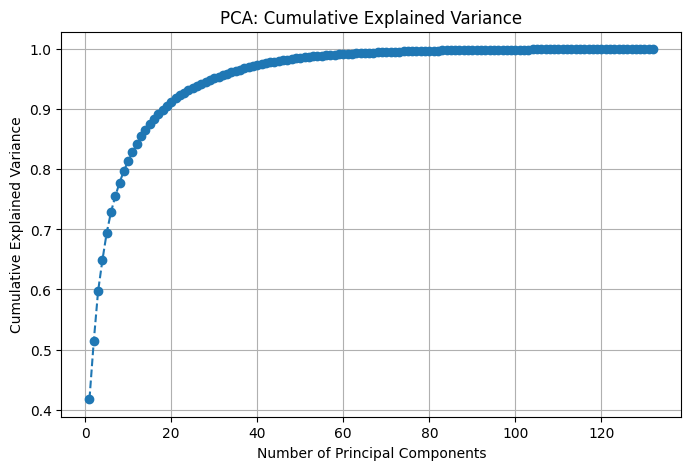

In [14]:
pca = PCA()
pca.fit(X_train_transformed)

# Compute cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.grid(True)
plt.show()


## Manual F Selection


Fold 1 | Train: 2007-01-05 00:00:00 → 2009-02-27 00:00:00 | Test: 2009-03-06 00:00:00 → 2011-04-29 00:00:00
----------Fold 1 Results: RMSE: 0.0267 | MAE: 0.0196 | DA: 0.5398

Fold 2 | Train: 2007-01-05 00:00:00 → 2011-04-29 00:00:00 | Test: 2011-05-06 00:00:00 → 2013-06-28 00:00:00
----------Fold 2 Results: RMSE: 0.0214 | MAE: 0.0155 | DA: 0.6726

Fold 3 | Train: 2007-01-05 00:00:00 → 2013-06-28 00:00:00 | Test: 2013-07-05 00:00:00 → 2015-08-28 00:00:00
----------Fold 3 Results: RMSE: 0.0152 | MAE: 0.0117 | DA: 0.6372

Fold 4 | Train: 2007-01-05 00:00:00 → 2015-08-28 00:00:00 | Test: 2015-09-04 00:00:00 → 2017-10-27 00:00:00
----------Fold 4 Results: RMSE: 0.0140 | MAE: 0.0101 | DA: 0.6814

Fold 5 | Train: 2007-01-05 00:00:00 → 2017-10-27 00:00:00 | Test: 2017-11-03 00:00:00 → 2019-12-27 00:00:00
----------Fold 5 Results: RMSE: 0.0183 | MAE: 0.0129 | DA: 0.7168

Time Series Cross-Validation Summary:
Mean RMSE: 0.0191 | 95% CI: (0.0151127402783806, 0.023105364268509804)
Mean MAE: 0.013

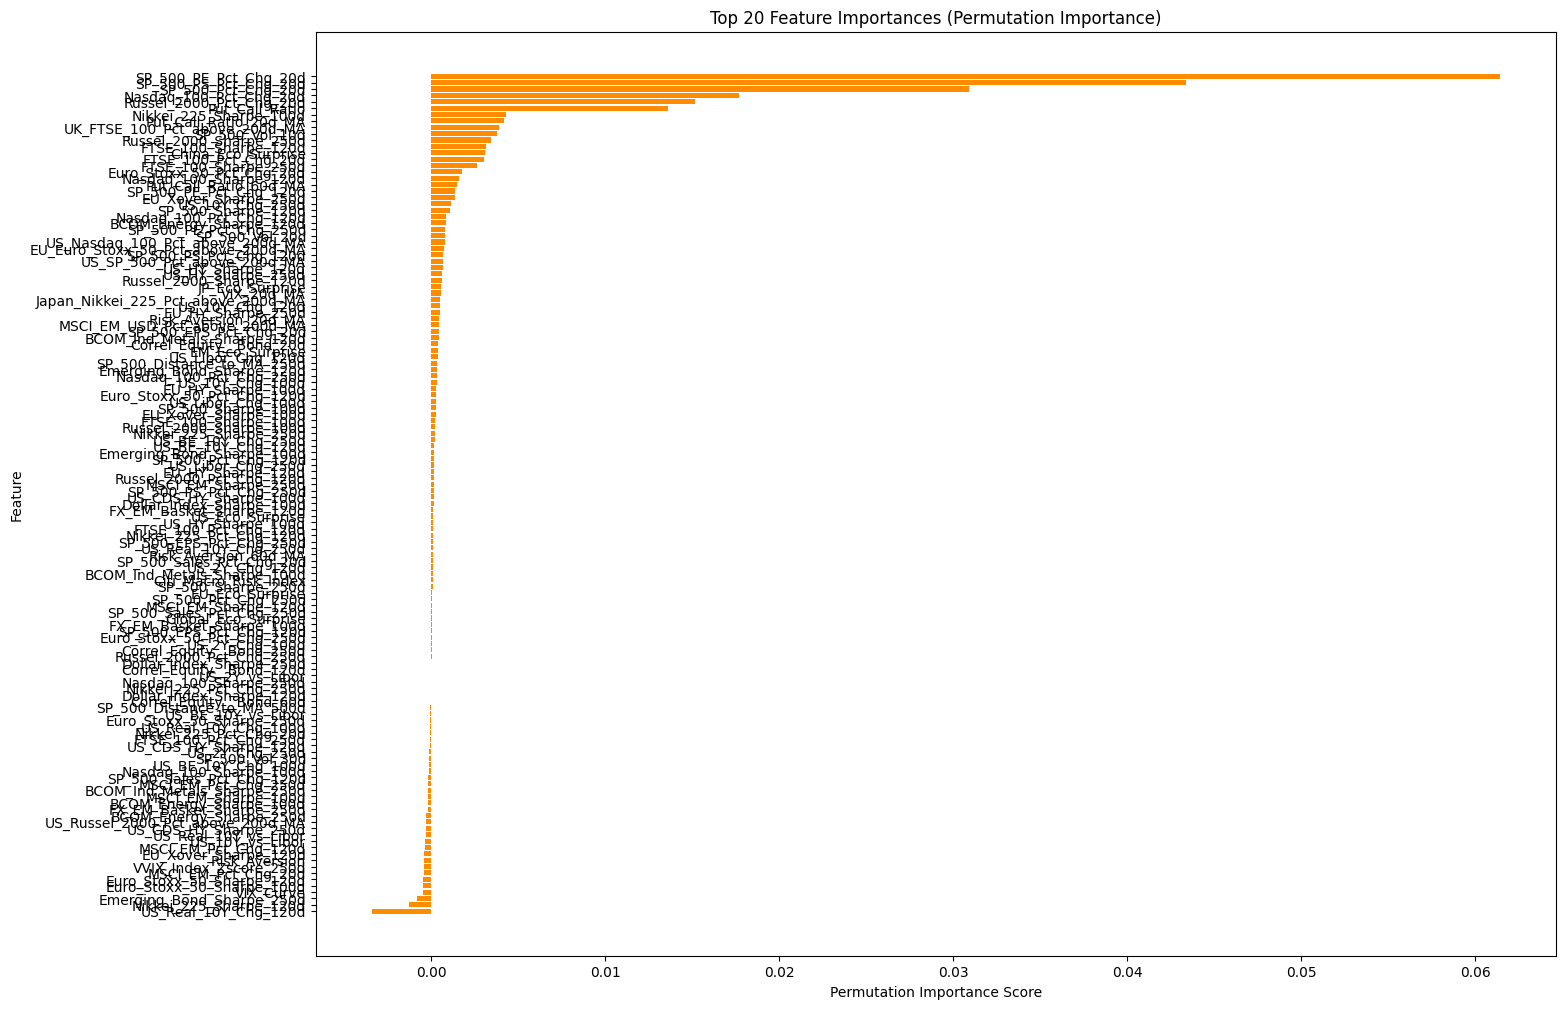

Less Important Features by Permutation Importance:
                           Permutation Importance
Feature                                          
EU_Xover_Sharpe_120d                    -0.000387
Risk_Aversion                           -0.000417
VVIX_Index_Zscore_250d                  -0.000427
MSCI_EM_Pct_Chg_20d                     -0.000430
Euro_Stoxx_50_Sharpe_120d               -0.000444
Euro_Stoxx_50_Sharpe_100d               -0.000448
VIX_Curve                               -0.000473
Emerging_Bond_Sharpe_250d               -0.000796
Nikkei_225_Sharpe_120d                  -0.001274
US_Real_10Y_Chg_120d                    -0.003387


In [16]:
extra_trees_model = ExtraTreesRegressor(n_estimators=1000, max_depth=6, random_state=42, n_jobs=-1)
xt_forecaster = Forecaster(model=extra_trees_model, n_splits=5)
extra_trees_model, results = xt_forecaster.time_series_cross_validation(X_train_scaled, y_train, X_train_scaled.index)


perm_importance = permutation_importance(extra_trees_model, X_test_transformed, y_test, n_repeats=10, random_state=42)

importance_df = pd.DataFrame({
    'Feature': X_train_transformed.columns,
    'Permutation Importance': perm_importance.importances_mean
}).set_index('Feature')

importance_df = importance_df.sort_values(by="Permutation Importance", ascending=False)

plt.figure(figsize=(16, 12))
plt.barh(importance_df.index, importance_df["Permutation Importance"], color="darkorange")
plt.xlabel("Permutation Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importances (Permutation Importance)")
plt.gca().invert_yaxis()
plt.show()

# Print the Most Important Features
print("Less Important Features by Permutation Importance:")
print(importance_df.tail(10))

In [60]:
low_importance_features = importance_df[importance_df["Permutation Importance"] < 0].index
X_train_transformed_filtered = X_train_transformed.drop(columns=low_importance_features)
X_test_transformed_filtered = X_test_transformed.drop(columns=low_importance_features)

In [61]:
corr_matrix = X_train_transformed_filtered.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Compute P-values for Each Pair of Features
p_values = pd.DataFrame(np.ones(corr_matrix.shape), index=X_train_transformed_filtered.columns, columns=X_train_transformed_filtered.columns)

for col in upper_tri.columns:
    for row in upper_tri.index:
        _, p_val = pearsonr(X_train_transformed_filtered[row], X_train_transformed_filtered[col])
        p_values.loc[row, col] = p_val

# Apply Bonferroni correction for Multiple Testing to avoid false psitive
p_values_flat = p_values.where(np.triu(np.ones(p_values.shape), k=1).astype(bool)).stack()
_, bonferroni_pvals, _, _ = multipletests(p_values_flat, alpha=0.05, method='bonferroni')
bonferroni_p_values = pd.DataFrame(np.ones(corr_matrix.shape), index=X_train_transformed_filtered.columns, columns=X_train_transformed_filtered.columns)
bonferroni_p_values.values[np.triu_indices_from(bonferroni_p_values, k=1)] = bonferroni_pvals

# Remove Highly Correlated Features (p < 0.05 After Bonferroni Correction)
threshold = 0.92
to_remove = set()

for col in upper_tri.columns:
    for row in upper_tri.index:
        if bonferroni_p_values.loc[row, col] < 0.05 and upper_tri.loc[row, col] > threshold:
            # Keep the feature that has the stronger correlation with y_train
            if abs(X_train_transformed_filtered[row].corr(y_train)) > abs(X_train_transformed_filtered[col].corr(y_train)):
                to_remove.add(col)
            else:
                to_remove.add(row)

X_train_transformed_filtered = X_train_transformed_filtered.drop(columns=to_remove)
X_test_transformed_filtered = X_test_transformed_filtered.drop(columns=to_remove)
print(f"Removed {len(to_remove)} highly correlated features.")
print("Remaining Features:", X_train_transformed_filtered.columns.tolist())


Removed 19 highly correlated features.
Remaining Features: ['SP_500_Pct_Chg_20d', 'Euro_Stoxx_50_Pct_Chg_20d', 'Euro_Stoxx_50_Pct_Chg_120d', 'Euro_Stoxx_50_Pct_Chg_250d', 'FTSE_100_Pct_Chg_20d', 'FTSE_100_Pct_Chg_120d', 'Nikkei_225_Pct_Chg_120d', 'US_10Y_Chg_100d', 'US_10Y_Chg_120d', 'US_10Y_Chg_250d', 'US_2Y_Chg_100d', 'US_Real_10Y_Chg_250d', 'US_BE_10Y_Chg_120d', 'US_BE_10Y_Chg_250d', 'US_Libor_Chg_120d', 'US_Libor_Chg_250d', 'Global_Eco_Surprise', 'US_Eco_Surprise', 'EU_Eco_Surprise', 'JP_Eco_Surprise', 'EM_Eco_Surprise', 'China_Eco_Surprise', 'SP_500_EPS_Pct_Chg_20d', 'SP_500_EPS_Pct_Chg_120d', 'SP_500_EPS_Pct_Chg_250d', 'SP_500_Sales_Pct_Chg_20d', 'SP_500_Sales_Pct_Chg_250d', 'SP_500_PS_Pct_Chg_120d', 'SP_500_PS_Pct_Chg_250d', 'SP_500_PE_Pct_Chg_120d', 'SP_500_PE_Pct_Chg_250d', 'BCOM_Energy_Sharpe_120d', 'BCOM_Ind_Metals_Sharpe_120d', 'FX_EM_Basket_Sharpe_120d', 'Dollar_Index_Sharpe_100d', 'Dollar_Index_Sharpe_250d', 'SP_500_Sharpe_100d', 'SP_500_Sharpe_120d', 'SP_500_Sharpe_250d'

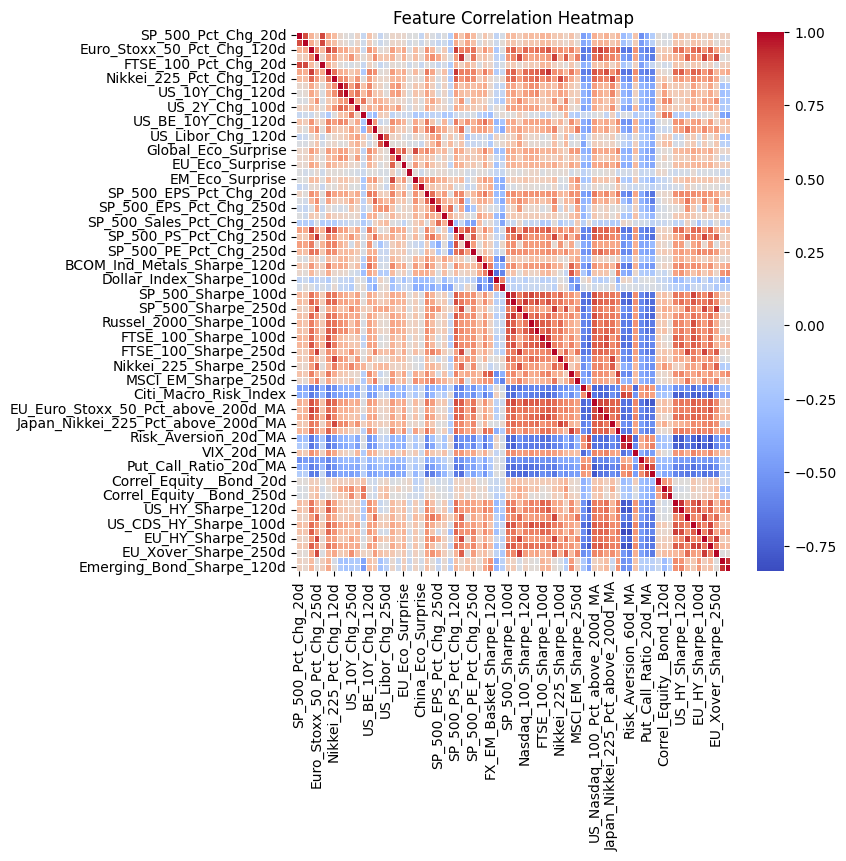

In [62]:
correlation_matrix = X_train_transformed_filtered.corr(method="pearson")
plt.figure(figsize=(7, 7))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5, cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

# Model Score

## PCA

In [55]:
n_components = 51
pca = PCA(n_components=n_components)

X_train_pca = pca.fit_transform(X_train_transformed)
X_test_pca = pca.transform(X_test_transformed)
X_train_pca = pd.DataFrame(X_train_pca, index=X_train_transformed.index, columns=[f'PC{i+1}' for i in range(n_components)])
X_test_pca = pd.DataFrame(X_test_pca, index=X_test_scaled.index, columns=[f'PC{i+1}' for i in range(n_components)])

In [56]:
linear_forecaster_pca = Forecaster(model=Ridge(), n_splits=5)
results = linear_forecaster_pca.time_series_cross_validation(X_train_pca, y_train, X_train_pca.index)



Fold 1 | Train: 2007-01-05 00:00:00 → 2009-02-27 00:00:00 | Test: 2009-03-06 00:00:00 → 2011-04-29 00:00:00
----------Fold 1 Results: RMSE: 0.1539 | MAE: 0.1343 | DA: 0.5310

Fold 2 | Train: 2007-01-05 00:00:00 → 2011-04-29 00:00:00 | Test: 2011-05-06 00:00:00 → 2013-06-28 00:00:00
----------Fold 2 Results: RMSE: 0.0586 | MAE: 0.0443 | DA: 0.5575

Fold 3 | Train: 2007-01-05 00:00:00 → 2013-06-28 00:00:00 | Test: 2013-07-05 00:00:00 → 2015-08-28 00:00:00
----------Fold 3 Results: RMSE: 0.0357 | MAE: 0.0287 | DA: 0.5575

Fold 4 | Train: 2007-01-05 00:00:00 → 2015-08-28 00:00:00 | Test: 2015-09-04 00:00:00 → 2017-10-27 00:00:00
----------Fold 4 Results: RMSE: 0.0412 | MAE: 0.0345 | DA: 0.4779

Fold 5 | Train: 2007-01-05 00:00:00 → 2017-10-27 00:00:00 | Test: 2017-11-03 00:00:00 → 2019-12-27 00:00:00
----------Fold 5 Results: RMSE: 0.0255 | MAE: 0.0203 | DA: 0.6372

Time Series Cross-Validation Summary:
Mean RMSE: 0.0630 | 95% CI: (0.022038616186025824, 0.10391736132156029)
Mean MAE: 0.05

#### The score has significantly improved as comapred to our LinearRegression baseline by keeping only few principal components that are uncorrelated eigenvector of our dataset covariance matrix

## Manual F.S

In [63]:
linear_forecaster = Forecaster(model=Ridge(), n_splits=5)
results = linear_forecaster.time_series_cross_validation(X_train_transformed_filtered, y_train, X_train_transformed_filtered.index)



Fold 1 | Train: 2007-01-05 00:00:00 → 2009-02-27 00:00:00 | Test: 2009-03-06 00:00:00 → 2011-04-29 00:00:00
----------Fold 1 Results: RMSE: 0.0988 | MAE: 0.0807 | DA: 0.5487

Fold 2 | Train: 2007-01-05 00:00:00 → 2011-04-29 00:00:00 | Test: 2011-05-06 00:00:00 → 2013-06-28 00:00:00
----------Fold 2 Results: RMSE: 0.0720 | MAE: 0.0557 | DA: 0.4867

Fold 3 | Train: 2007-01-05 00:00:00 → 2013-06-28 00:00:00 | Test: 2013-07-05 00:00:00 → 2015-08-28 00:00:00
----------Fold 3 Results: RMSE: 0.0236 | MAE: 0.0178 | DA: 0.6726

Fold 4 | Train: 2007-01-05 00:00:00 → 2015-08-28 00:00:00 | Test: 2015-09-04 00:00:00 → 2017-10-27 00:00:00
----------Fold 4 Results: RMSE: 0.0306 | MAE: 0.0254 | DA: 0.5133

Fold 5 | Train: 2007-01-05 00:00:00 → 2017-10-27 00:00:00 | Test: 2017-11-03 00:00:00 → 2019-12-27 00:00:00
----------Fold 5 Results: RMSE: 0.0332 | MAE: 0.0272 | DA: 0.5310

Time Series Cross-Validation Summary:
Mean RMSE: 0.0517 | 95% CI: (0.02623992614377296, 0.07707053959880882)
Mean MAE: 0.041

In [64]:
ext_forecaster = Forecaster(model=ExtraTreesRegressor(), n_splits=5)
extree_model, results = ext_forecaster.time_series_cross_validation(X_train_transformed_filtered, y_train, X_train_transformed_filtered.index)



Fold 1 | Train: 2007-01-05 00:00:00 → 2009-02-27 00:00:00 | Test: 2009-03-06 00:00:00 → 2011-04-29 00:00:00
----------Fold 1 Results: RMSE: 0.0286 | MAE: 0.0215 | DA: 0.4956

Fold 2 | Train: 2007-01-05 00:00:00 → 2011-04-29 00:00:00 | Test: 2011-05-06 00:00:00 → 2013-06-28 00:00:00
----------Fold 2 Results: RMSE: 0.0205 | MAE: 0.0150 | DA: 0.6637

Fold 3 | Train: 2007-01-05 00:00:00 → 2013-06-28 00:00:00 | Test: 2013-07-05 00:00:00 → 2015-08-28 00:00:00
----------Fold 3 Results: RMSE: 0.0157 | MAE: 0.0121 | DA: 0.6372

Fold 4 | Train: 2007-01-05 00:00:00 → 2015-08-28 00:00:00 | Test: 2015-09-04 00:00:00 → 2017-10-27 00:00:00
----------Fold 4 Results: RMSE: 0.0134 | MAE: 0.0094 | DA: 0.6903

Fold 5 | Train: 2007-01-05 00:00:00 → 2017-10-27 00:00:00 | Test: 2017-11-03 00:00:00 → 2019-12-27 00:00:00
----------Fold 5 Results: RMSE: 0.0174 | MAE: 0.0125 | DA: 0.7257

Time Series Cross-Validation Summary:
Mean RMSE: 0.0191 | 95% CI: (0.014522755112801067, 0.023766003936063276)
Mean MAE: 0.0

# Best Model Fine Tuning

In [66]:
param_grid = {
    "n_estimators": [100, 200, 500, 1000],  # Number of trees
    "max_depth": [None, 10, 20, 30],  # Depth of trees
    "min_samples_split": [2, 5, 10],  # Minimum samples per split
    "max_features": ["sqrt", "log2", None],  # Feature selection
}

def custom_scorer(y_true, y_pred, beta=0.9):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    da = np.mean(np.sign(y_true) == np.sign(y_pred))
    return (1-beta) * da - beta * rmse

custom_scorer = make_scorer(custom_scorer, greater_is_better=True)
tscv = TimeSeriesSplit(n_splits=5)
base_model = ExtraTreesRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=20,  
    cv=tscv,
    scoring=custom_scorer,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_transformed_filtered, y_train)
best_model = random_search.best_estimator_

print("\nBest Hyperparameters:")
print(random_search.best_params_)
print(f"Best Customized Score: {random_search.best_score_:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Hyperparameters:
{'n_estimators': 1000, 'min_samples_split': 2, 'max_features': None, 'max_depth': None}
Best Customized Score: 0.0492


In [67]:
param_grid = {
    "alpha": np.logspace(-2, 2, 50)
}

base_model = Ridge()
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=20,
    cv=tscv,
    scoring=custom_scorer,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_transformed_filtered, y_train)
best_linear_model = random_search.best_estimator_

print("\nBest Hyperparameters (Ridge Regression):")
print(random_search.best_params_)
print(f"Best Customized Score: {random_search.best_score_:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Hyperparameters (Ridge Regression):
{'alpha': 82.86427728546842}
Best Customized Score: 0.0444


##  Final Prediction

In [68]:
final_forecaster = Forecaster(model=best_model, n_splits=5)
best_model, results = final_forecaster.time_series_cross_validation(X_train_transformed_filtered, y_train, X_train_transformed_filtered.index)
best_model, y_pred_test = final_forecaster.test_prediction(X_train_transformed_filtered, y_train, X_test_transformed_filtered, y_test)

df = pd.DataFrame({
    'pred': y_pred_test,
    'true ': y_test  })
df


Fold 1 | Train: 2007-01-05 00:00:00 → 2009-02-27 00:00:00 | Test: 2009-03-06 00:00:00 → 2011-04-29 00:00:00
----------Fold 1 Results: RMSE: 0.0279 | MAE: 0.0206 | DA: 0.5310

Fold 2 | Train: 2007-01-05 00:00:00 → 2011-04-29 00:00:00 | Test: 2011-05-06 00:00:00 → 2013-06-28 00:00:00
----------Fold 2 Results: RMSE: 0.0204 | MAE: 0.0151 | DA: 0.6726

Fold 3 | Train: 2007-01-05 00:00:00 → 2013-06-28 00:00:00 | Test: 2013-07-05 00:00:00 → 2015-08-28 00:00:00
----------Fold 3 Results: RMSE: 0.0149 | MAE: 0.0113 | DA: 0.6726

Fold 4 | Train: 2007-01-05 00:00:00 → 2015-08-28 00:00:00 | Test: 2015-09-04 00:00:00 → 2017-10-27 00:00:00
----------Fold 4 Results: RMSE: 0.0133 | MAE: 0.0095 | DA: 0.6726

Fold 5 | Train: 2007-01-05 00:00:00 → 2017-10-27 00:00:00 | Test: 2017-11-03 00:00:00 → 2019-12-27 00:00:00
----------Fold 5 Results: RMSE: 0.0171 | MAE: 0.0123 | DA: 0.7522

Time Series Cross-Validation Summary:
Mean RMSE: 0.0187 | 95% CI: (0.01418718001245712, 0.023261695184781085)
Mean MAE: 0.01

,pred,true
2020-01-03,0.008609,-0.001295
2020-01-10,0.008019,0.009036
2020-01-17,0.006981,0.018971
2020-01-24,0.003324,-0.010218
2020-01-31,-0.000929,-0.021549
...,...,...
2024-03-22,0.008342,0.021699
2024-03-29,0.005920,0.002926
2024-04-05,-0.001567,-0.010612
2024-04-12,0.003740,-0.016949


In [69]:
final_forecaster = Forecaster(model=best_linear_model, n_splits=5)
best_model, results = final_forecaster.time_series_cross_validation(X_train_transformed_filtered, y_train, X_train_transformed_filtered.index)
best_model, y_pred_test = final_forecaster.test_prediction(X_train_transformed_filtered, y_train, X_test_transformed_filtered, y_test)

df = pd.DataFrame({
    'pred': y_pred_test,
    'true ': y_test  })
df


Fold 1 | Train: 2007-01-05 00:00:00 → 2009-02-27 00:00:00 | Test: 2009-03-06 00:00:00 → 2011-04-29 00:00:00
----------Fold 1 Results: RMSE: 0.0247 | MAE: 0.0184 | DA: 0.5752

Fold 2 | Train: 2007-01-05 00:00:00 → 2011-04-29 00:00:00 | Test: 2011-05-06 00:00:00 → 2013-06-28 00:00:00
----------Fold 2 Results: RMSE: 0.0205 | MAE: 0.0159 | DA: 0.5575

Fold 3 | Train: 2007-01-05 00:00:00 → 2013-06-28 00:00:00 | Test: 2013-07-05 00:00:00 → 2015-08-28 00:00:00
----------Fold 3 Results: RMSE: 0.0165 | MAE: 0.0126 | DA: 0.6460

Fold 4 | Train: 2007-01-05 00:00:00 → 2015-08-28 00:00:00 | Test: 2015-09-04 00:00:00 → 2017-10-27 00:00:00
----------Fold 4 Results: RMSE: 0.0155 | MAE: 0.0107 | DA: 0.6283

Fold 5 | Train: 2007-01-05 00:00:00 → 2017-10-27 00:00:00 | Test: 2017-11-03 00:00:00 → 2019-12-27 00:00:00
----------Fold 5 Results: RMSE: 0.0175 | MAE: 0.0126 | DA: 0.6637

Time Series Cross-Validation Summary:
Mean RMSE: 0.0189 | 95% CI: (0.01601987564964803, 0.021844247390149018)
Mean MAE: 0.01

,pred,true
2020-01-03,0.005440,-0.001295
2020-01-10,0.007807,0.009036
2020-01-17,0.008776,0.018971
2020-01-24,-0.000394,-0.010218
2020-01-31,-0.005226,-0.021549
...,...,...
2024-03-22,0.015932,0.021699
2024-03-29,0.011314,0.002926
2024-04-05,0.006604,-0.010612
2024-04-12,0.012058,-0.016949


- Extratrees:There is a slight overfit since the results ont the test set are less than in the training set, we could reduce the complexity of the model and use less features
- Ridge Regression is more robust and exibits good generalization performance on the test set which is encouraging